## 1. Config

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing.imputers import SimpleImputerDF
from preprocessing.feature_extraction import FeatureExtractor
from preprocessing.transformers import OneHotEncoderDF, LogTransformerDF, OrdinalEncoderDF

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from models.datasets import UsersProfilesDataset
from models.models import ProfileClassifier

from sklearn.metrics import mean_squared_error

import torch

In [2]:
DATA_DIRECTORY = './data'
PERSONALITY_FILE_PATH = os.path.join(DATA_DIRECTORY, 'data science task personality.csv')
USERS_FILE_PATH = os.path.join(DATA_DIRECTORY, 'data science task users.csv')

RANDOM_STATE = 42

TEST_SIZE = 0.2

## 2. Data loading

In [3]:
df_p = pd.read_csv(PERSONALITY_FILE_PATH)

df_p.head()

,UserIdentifier,A,B,C,D,E
0,d2d10f362bb1d0092174a660778cbe50,0.041197,-0.389188,-0.257404,0.732678,-0.769127
1,083a56a91d0d1ee4e66643849133b2b3,-0.596461,0.620304,-0.611045,-0.256928,-0.244441
2,fdc1004b329f2aca4c81ad59c93c1be0,-1.198166,-0.821102,0.298394,-0.031738,0.821793
3,8b8a4372a0f3fd3e1a1d4c531211506e,-0.344910,-1.611630,0.220709,-0.323851,-0.127276
4,58d0c701bf73a5949e2ee29f387fb5a2,-0.365047,1.094319,-0.187957,-0.254589,0.554409


In [4]:
df_u = pd.read_csv(USERS_FILE_PATH)

df_u.head()

,UserIdentifier,UserBrowser,D01,D02,D03,D04,D05,D06,D07
0,d2d10f362bb1d0092174a660778cbe50,Firefox 69.0 (Desktop),M,1954.0,3.0,4.0,2.0,6.0,2.0
1,083a56a91d0d1ee4e66643849133b2b3,Chrome 70.0.3538.110 (Mobile),M,1963.0,2.0,2.0,2.0,7.0,2.0
2,fdc1004b329f2aca4c81ad59c93c1be0,Chrome 77.0.3865.90 (Desktop),K,1975.0,4.0,1.0,4.0,5.0,6.0
3,8b8a4372a0f3fd3e1a1d4c531211506e,Chrome 75.0.3770.142 (Desktop),K,1991.0,3.0,2.0,4.0,5.0,4.0
4,58d0c701bf73a5949e2ee29f387fb5a2,Chrome 78.0.3904.108 (Mobile),M,2000.0,3.0,3.0,1.0,7.0,6.0


## 3. Base data quality checks

In [5]:
print(f'DataFrame personality: \n', 30*'-')
print(f'shape: {df_p.shape}')
print(f'distinct UserIdentifier: {len(set(df_p.UserIdentifier))}')
print(f'null values: \n{np.sum(df_p.isnull())}')

print(f'\nDataFrame users: \n', 30*'-')
print(f'shape: {df_u.shape}')
print(f'distinct UserIdentifier: {len(set(df_u.UserIdentifier))}')
print(f'null values: \n{np.sum(df_u.isnull())}')

DataFrame personality: 
 ------------------------------
shape: (1681, 6)
distinct UserIdentifier: 1521
null values: 
UserIdentifier     0
A                  4
B                 10
C                 13
D                  5
E                  5
dtype: int64

DataFrame users: 
 ------------------------------
shape: (1868, 9)
distinct UserIdentifier: 1679
null values: 
UserIdentifier    0
UserBrowser       0
D01               0
D02               0
D03               0
D04               0
D05               1
D06               1
D07               1
dtype: int64


## 4. Preprocessing

### 4.1 Drop duplicates

In [6]:
df_p_unique = df_p.drop_duplicates(keep='first').set_index('UserIdentifier')
df_u_unique = df_u.drop_duplicates(keep='first').set_index('UserIdentifier')

### 4.2 Merge sets

In [7]:
df_all = pd.merge(
    left=df_u_unique,
    right=df_p_unique,
    how='left',
    left_index=True,
    right_index=True
)
df_all.shape

(1695, 13)

In [8]:
df_all[df_all.isnull().any(axis=1)]

,UserBrowser,D01,D02,D03,D04,D05,D06,D07,A,B,C,D,E
UserIdentifier,,,,,,,,,,,,,
007079c718eff3683d244e6bceb67f35,Firefox 71.0 (Desktop),K,1968.0,3.0,2.0,1.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN
00e33b78167c8685d643895b637bd462,Chrome 77.0.3865.90 (Desktop),M,1974.0,4.0,2.0,5.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN
021c9be32665a83b806ab5a07f140c46,Chrome 78.0.3904.108 (Mobile),M,1981.0,3.0,2.0,4.0,10.0,2.0,NaN,NaN,NaN,NaN,NaN
02cf10f9afb8c7c6f5d5c5983788185a,Chrome 79.0.3945.130 (Desktop),M,1997.0,4.0,2.0,4.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN
04faae14580b8db0962e85991a9114ba,Chrome 78.0.3904.108 (Desktop),K,1982.0,3.0,1.0,4.0,10.0,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb21c4d442ad5939bee4257679eb63ac,Chrome 80.0.3987.87 (Mobile),K,1995.0,3.0,6.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
fb551347615ac13f503482196a2ee8d9,Chrome 71.0.3578.99 (Mobile),K,1993.0,3.0,3.0,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN
fe752ba7a82ba3275adb99471912038c,Chrome 78.0.3904.108 (Mobile),M,1991.0,4.0,2.0,4.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN


## 4.3 Train/test split

In [9]:
users_train, users_test, profiles_train, profiles_test = train_test_split(
    df_all[df_u_unique.columns],
    df_all[df_p_unique.columns],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## 4.4 Data imputation

In [10]:
profiles_train[profiles_train.isnull().any(axis=1)]

,A,B,C,D,E
UserIdentifier,,,,,
6752362b8c7a9a90f54419ee610798e2,NaN,NaN,NaN,NaN,NaN
d86a7c34221256b8a368066de6ce1f52,NaN,NaN,NaN,NaN,NaN
574c63403d610abdcaf84020a38cbd04,NaN,NaN,NaN,NaN,NaN
fa50c6662943de3ade10378cf74ffd50,NaN,NaN,NaN,NaN,NaN
07bdb7bd96871fa49af5650ae7507867,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
e036fce4a27b3b658ff394100c4b7661,NaN,0.361130,-0.056259,0.113367,-0.229832
ee7889cb44e0a690fc75227219529312,NaN,NaN,NaN,NaN,NaN
b452b360dbd9901b36a8a225ecc820e1,NaN,NaN,NaN,NaN,NaN


In [11]:
imputer_profiles = SimpleImputerDF(strategy='constant', fill_value_num=0.0)

profiles_train = imputer_profiles.fit_transform(profiles_train) 

In [12]:
users_train[users_train.isnull().any(axis=1)]

,UserBrowser,D01,D02,D03,D04,D05,D06,D07
UserIdentifier,,,,,,,,
afe841be2dababac5a440e0c14a9f903,Chrome 78.0.3904.108 (Mobile),K,1981.0,4.0,2.0,NaN,NaN,NaN


In [13]:
imputer_users = SimpleImputerDF(strategy='constant', fill_value_num=-1.0)

users_train = imputer_users.fit_transform(users_train)

## 5. Preprocessing

In [14]:
feature_list_freq_encoding = [
    'browser_version'
]
feature_list_one_hot_encoding = [
    'D01',
    'D03',
    'D04',
    'D05',
    'D06',
    'D07',
    'browser_name',
    'device_type'
]
feature_list_log_scaling = [
    'age'
]

In [15]:
feature_extractor = FeatureExtractor(n_jobs=-1)
users_train = feature_extractor.fit_transform(users_train)

users_train.head()

,D01,D03,D04,D05,D06,D07,browser_name,browser_version,device_type,age
UserIdentifier,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,K,4.0,2.0,2.0,5.0,2.0,Chrome,78.00039,Mobile,53
c84e93e811adfa031ae4254dddb797f5,K,3.0,4.0,2.0,2.0,1.0,Firefox,52.00000,Desktop,72
5a94f488ddf508fec534ecb91f3d7a05,K,4.0,2.0,3.0,8.0,3.0,Firefox,52.00000,Desktop,42
99d5bfc07d78c0dea2330be4e2427a85,K,4.0,3.0,1.0,8.0,3.0,Chrome,78.00039,Mobile,29
d89368a53b1fc5082d0222e1bd71ad15,K,3.0,2.0,3.0,6.0,3.0,Chrome,78.00039,Desktop,26


In [16]:
ordinal_encoder = OrdinalEncoderDF(['device_type', 'browser_name'], 'browser_version')
users_train = ordinal_encoder.fit_transform(users_train)

users_train.head()

,D01,D03,D04,D05,D06,D07,browser_name,device_type,age,browser_version_rank
UserIdentifier,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,K,4.0,2.0,2.0,5.0,2.0,Chrome,Mobile,53,11.0
c84e93e811adfa031ae4254dddb797f5,K,3.0,4.0,2.0,2.0,1.0,Firefox,Desktop,72,10.0
5a94f488ddf508fec534ecb91f3d7a05,K,4.0,2.0,3.0,8.0,3.0,Firefox,Desktop,42,10.0
99d5bfc07d78c0dea2330be4e2427a85,K,4.0,3.0,1.0,8.0,3.0,Chrome,Mobile,29,11.0
d89368a53b1fc5082d0222e1bd71ad15,K,3.0,2.0,3.0,6.0,3.0,Chrome,Desktop,26,15.0


In [17]:
onehot_encoder = OneHotEncoderDF(feature_list_one_hot_encoding)
users_train = onehot_encoder.fit_transform(users_train)

users_train.head()

,age,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,...,browser_name_chrome,browser_name_edge,browser_name_firefox,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,53,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
c84e93e811adfa031ae4254dddb797f5,72,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5a94f488ddf508fec534ecb91f3d7a05,42,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99d5bfc07d78c0dea2330be4e2427a85,29,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
d89368a53b1fc5082d0222e1bd71ad15,26,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [18]:
log_transformer = LogTransformerDF(feature_list_log_scaling)
users_train = log_transformer.fit_transform(users_train)

users_train.head()

,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,d04_2_0,...,browser_name_edge,browser_name_firefox,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,age_log
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
6752362b8c7a9a90f54419ee610798e2,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.637586
c84e93e811adfa031ae4254dddb797f5,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.043051
5a94f488ddf508fec534ecb91f3d7a05,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.295837
99d5bfc07d78c0dea2330be4e2427a85,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.639057
d89368a53b1fc5082d0222e1bd71ad15,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.397895


### 5.1 Transform test dataset

In [19]:
# Profiles
profiles_test = imputer_profiles.transform(profiles_test)

# Users
users_test = imputer_users.transform(users_test)
users_test = feature_extractor.transform(users_test)
users_test = ordinal_encoder.transform(users_test)
users_test = onehot_encoder.transform(users_test)
users_test = log_transformer.transform(users_test)

users_test.head()

,browser_version_rank,d01_k,d01_m,d03_1_0,d03_2_0,d03_3_0,d03_4_0,d03_5_0,d04_1_0,d04_2_0,...,browser_name_edge,browser_name_firefox,browser_name_generic,browser_name_ie,browser_name_opera,browser_name_safari,device_type_desktop,device_type_mobile,device_type_tablet,age_log
UserIdentifier,,,,,,,,,,,,,,,,,,,,,
89f970118311aca77a98f4a18f163726,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.465736
d09a98da4db82b1939e3183ddb1f8e69,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.484907
ea7a103e859ef8718e244b81f7384b20,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.912023
94e3018710af7b51e95c6243ee6cc224,11.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.258097
47bbe37bab5252eddf884b9d4ce6e3f0,11.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.218876


## 6. Visualization

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1356 samples in 0.004s...
[t-SNE] Computed neighbors for 1356 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1356
[t-SNE] Computed conditional probabilities for sample 1356 / 1356
[t-SNE] Mean sigma: 0.952913
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.494659
[t-SNE] KL divergence after 1000 iterations: 1.628392


<AxesSubplot:>

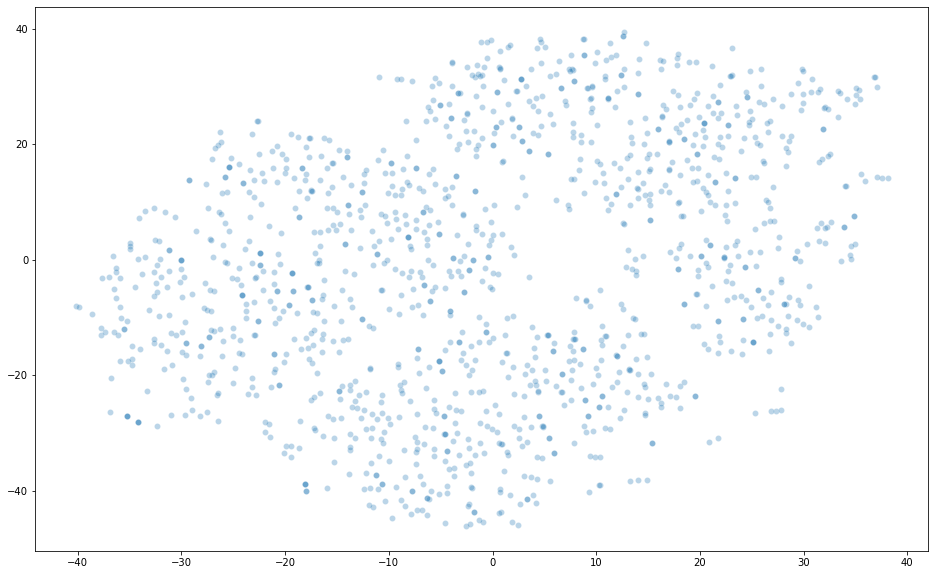

In [20]:
# Scale data
users_train_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(users_train), index=users_train.index, columns=users_train.columns)

# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(users_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1356 samples in 0.001s...
[t-SNE] Computed neighbors for 1356 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1356
[t-SNE] Computed conditional probabilities for sample 1356 / 1356
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.482040
[t-SNE] KL divergence after 1000 iterations: 1.333789


<AxesSubplot:>

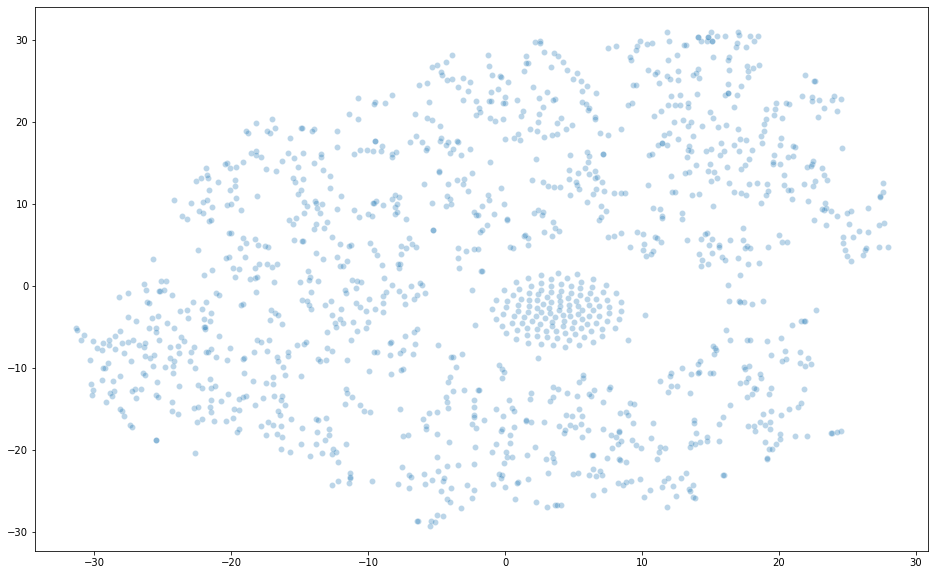

In [21]:
# Scale data
profiles_train_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(profiles_train), index=profiles_train.index, columns=profiles_train.columns)

# Calculate t-sne components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
tsne_results = tsne.fit_transform(profiles_train_scaled)

# Visualize
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

## 7. Connection between datasets

In [22]:
INPUT_SIZE = users_train.shape[1]
OUTPUT_SIZE = profiles_train.shape[1]

N_EPOCHS = 1000
BATCH_SIZE = 128
LR = 0.00001

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# Scale test data
users_test_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(users_test), index=users_test.index, columns=users_test.columns)

# Merge data
df_train = pd.merge(
    left=users_train_scaled, 
    right=profiles_train,
    how='inner',
    left_index=True,
    right_index=True
)
df_test = pd.merge(
    left=users_test_scaled, 
    right=profiles_test,
    how='inner',
    left_index=True,
    right_index=True
)

# Initialize Datasets
ds_train = UsersProfilesDataset(df_train)
ds_test = UsersProfilesDataset(df_test)

# Initialize Sampler
sampler = torch.utils.data.RandomSampler(ds_train)

# Initialize DataLoader
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE)

# Model params
net = ProfileClassifier(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [24]:
@torch.no_grad()
def evaluate_model(model, data_loader, print_info=False):
    
    model.eval()
    collect_results = []
    collect_targets = []

    for batch in data_loader:
        X, y = batch
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE).detach().cpu().numpy()

        pred = model(X)
        collect_results.append(pred.detach().cpu().numpy())
        collect_targets.append(y)

    preds = np.concatenate(collect_results)
    targets = np.concatenate(collect_targets)

    mse = mean_squared_error(targets, preds)

    if print_info:
        print(f'test mse: {mse}')

    model.train()
        
    return mse

In [25]:
losses = []
metrics = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(f'EPOCH={epoch + 1}')
    for X, y in train_dl:
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE)
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    train_ll = evaluate_model(net, train_dl)
    test_ll = evaluate_model(net, test_dl)
    
    print(f'train: loss={train_ll}')
    print(f'test: loss={test_ll}')
          
    metrics.append([train_ll, test_ll])

EPOCH=1
train: loss=0.6588238477706909
test: loss=0.6403194665908813
EPOCH=2
train: loss=0.6581981778144836
test: loss=0.639737606048584
EPOCH=3
train: loss=0.657566487789154
test: loss=0.639160692691803
EPOCH=4
train: loss=0.6569263935089111
test: loss=0.6385756134986877
EPOCH=5
train: loss=0.6563218832015991
test: loss=0.6380226016044617
EPOCH=6
train: loss=0.6556972861289978
test: loss=0.6374483108520508
EPOCH=7
train: loss=0.6551373600959778
test: loss=0.6369493007659912
EPOCH=8
train: loss=0.6545756459236145
test: loss=0.6364428997039795
EPOCH=9
train: loss=0.6540694236755371
test: loss=0.6359876990318298
EPOCH=10
train: loss=0.6535325050354004
test: loss=0.6355071663856506
EPOCH=11
train: loss=0.6529632210731506
test: loss=0.6349697113037109
EPOCH=12
train: loss=0.6524050831794739
test: loss=0.6344265341758728
EPOCH=13
train: loss=0.6518348455429077
test: loss=0.6338784694671631
EPOCH=14
train: loss=0.6512290239334106
test: loss=0.6333128809928894
EPOCH=15
train: loss=0.650609552

<AxesSubplot:>

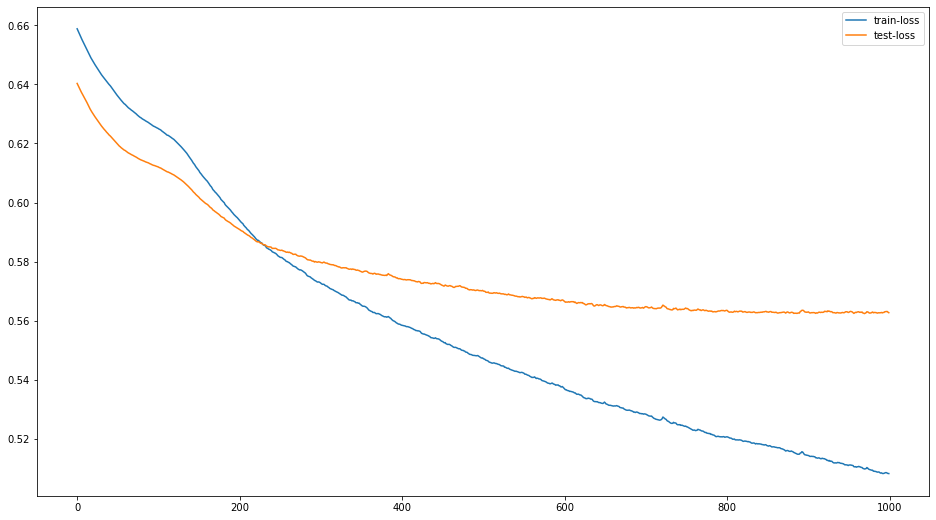

In [26]:
%matplotlib inline
pd.DataFrame(metrics, columns=['train-loss','test-loss']).plot(subplots=False, figsize=(16,9))

## 8. Clustering

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, 01f0606fa8a3a84456f7591b3e3cb7d1 to fe5cfe8d3b4004dc77505691eb7fe079
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   browser_version_rank  347 non-null    float64
 1   d01_k                 347 non-null    float64
 2   d01_m                 347 non-null    float64
 3   d03_1_0               347 non-null    float64
 4   d03_2_0               347 non-null    float64
 5   d03_3_0               347 non-null    float64
 6   d03_4_0               347 non-null    float64
 7   d03_5_0               347 non-null    float64
 8   d04_1_0               347 non-null    float64
 9   d04_2_0               347 non-null    float64
 10  d04_3_0               347 non-null    float64
 11  d04_4_0               347 non-null    float64
 12  d04_5_0               347 non-null    float64
 13  d04_6_0               347 non-null    float64
 14  d04_7_0            

### 8.1 User profiles